<a href="https://colab.research.google.com/github/kushal-jaat/ASD-assignment-3/blob/main/salesdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import pandas as pd
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from scipy.sparse import hstack

In [2]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 17.1 MB/s eta 0:00:00


In [3]:
# Mount Google Drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')
# Loading the dataset
sales_data = pd.read_csv('/content/drive/My Drive/housing/housing-sales-borough.csv')
# Display the first few rows
print(sales_data.head())

Mounted at /content/drive


<ipython-input-3-e82dd8e957b0>:5: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('/content/drive/My Drive/housing/housing-sales-borough.csv')


   Serial Number  List Year Date Recorded     Town          Address  \
0        2020177       2020    04/14/2021  Ansonia    323 BEAVER ST   
1        2020225       2020    05/26/2021  Ansonia   152 JACKSON ST   
2        2020348       2020    09/13/2021  Ansonia  230 WAKELEE AVE   
3        2020090       2020    12/14/2020  Ansonia      57 PLATT ST   
4         200500       2020    09-07-2021     Avon     245 NEW ROAD   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0          133000     248400.0       0.5354   Residential    Single Family   
1          110500     239900.0       0.4606   Residential     Three Family   
2          150500     325000.0       0.4630    Commercial              NaN   
3          127400     202500.0       0.6291   Residential       Two Family   
4          217640     400000.0       0.5441   Residential    Single Family   

  Non Use Code Assessor Remarks OPM remarks                    Location  
0          NaN              Na

In [4]:
# Inspecting the data structure
sales_data.info()
print(sales_data.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1048575 non-null  int64  
 1   List Year         1048575 non-null  int64  
 2   Date Recorded     1048573 non-null  object 
 3   Town              1048575 non-null  object 
 4   Address           1048524 non-null  object 
 5   Assessed Value    1048575 non-null  int64  
 6   Sale Amount       1048575 non-null  float64
 7   Sales Ratio       1048575 non-null  float64
 8   Property Type     666129 non-null   object 
 9   Residential Type  655012 non-null   object 
 10  Non Use Code      301508 non-null   object 
 11  Assessor Remarks  160753 non-null   object 
 12  OPM remarks       11422 non-null    object 
 13  Location          249058 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 112.0+ MB
        Serial Number     List Year Dat

In [5]:
# Check for missing values in sales
print(sales_data.isnull().sum())

Serial Number             0
List Year                 0
Date Recorded             2
Town                      0
Address                  51
Assessed Value            0
Sale Amount               0
Sales Ratio               0
Property Type        382446
Residential Type     393563
Non Use Code         747067
Assessor Remarks     887822
OPM remarks         1037153
Location             799517
dtype: int64


In [6]:
# Fill missing values for specific columns
sales_data['Property Type'] = sales_data['Property Type'].fillna("Unknown")
sales_data['Residential Type'] = sales_data['Residential Type'].fillna("Unknown")
sales_data['Non Use Code'] = sales_data['Non Use Code'].fillna("Unknown")

# Check if missing values are handled
print(sales_data.isnull().sum())



Serial Number             0
List Year                 0
Date Recorded             2
Town                      0
Address                  51
Assessed Value            0
Sale Amount               0
Sales Ratio               0
Property Type             0
Residential Type          0
Non Use Code              0
Assessor Remarks     887822
OPM remarks         1037153
Location             799517
dtype: int64


In [7]:
# check unique types in each column
def check_column_types(data, sample_size=None):
    mixed_type_columns = {}
    for col in data.columns:
        print(f"\nChecking column: '{col}'")

        # Sample data if sample_size is provided
        if sample_size:
            col_data = data[col].sample(sample_size, random_state=42)
        else:
            col_data = data[col]

        # Check for empty columns
        if col_data.isnull().all():
            print("  This column is empty.")
            continue

        # Count unique data types
        type_counts = col_data.apply(type).value_counts()
        print(type_counts)

        # Store columns with more than one type for summary
        if len(type_counts) > 1:
            mixed_type_columns[col] = type_counts

    # Print summary of columns with mixed types
    if mixed_type_columns:
        print("\nSummary of columns with mixed data types:")
        for col, types in mixed_type_columns.items():
            print(f"\nColumn '{col}':")
            print(types)
    else:
        print("\nNo columns with mixed data types found.")

# Usage
check_column_types(sales_data, sample_size=None)



Checking column: 'Serial Number'
Serial Number
<class 'int'>    1048575
Name: count, dtype: int64

Checking column: 'List Year'
List Year
<class 'int'>    1048575
Name: count, dtype: int64

Checking column: 'Date Recorded'
Date Recorded
<class 'str'>      1048573
<class 'float'>          2
Name: count, dtype: int64

Checking column: 'Town'
Town
<class 'str'>    1048575
Name: count, dtype: int64

Checking column: 'Address'
Address
<class 'str'>      1048524
<class 'float'>         51
Name: count, dtype: int64

Checking column: 'Assessed Value'
Assessed Value
<class 'int'>    1048575
Name: count, dtype: int64

Checking column: 'Sale Amount'
Sale Amount
<class 'float'>    1048575
Name: count, dtype: int64

Checking column: 'Sales Ratio'
Sales Ratio
<class 'float'>    1048575
Name: count, dtype: int64

Checking column: 'Property Type'
Property Type
<class 'str'>    1048575
Name: count, dtype: int64

Checking column: 'Residential Type'
Residential Type
<class 'str'>    1048575
Name: count,

In [8]:
# Handling mixed data types in the dataset
sales_data['Non Use Code'] = sales_data['Non Use Code'].astype(str)

# Verify data types after cleaning
for col in sales_data.columns:
    print(f"{col}: {sales_data[col].dtype}")

# Checking unique types again for mixed data types
for col in sales_data.columns:
    print(f"\nUnique types in column '{col}':")
    print(sales_data[col].apply(type).value_counts())


Serial Number: int64
List Year: int64
Date Recorded: object
Town: object
Address: object
Assessed Value: int64
Sale Amount: float64
Sales Ratio: float64
Property Type: object
Residential Type: object
Non Use Code: object
Assessor Remarks: object
OPM remarks: object
Location: object

Unique types in column 'Serial Number':
Serial Number
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'List Year':
List Year
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'Date Recorded':
Date Recorded
<class 'str'>      1048573
<class 'float'>          2
Name: count, dtype: int64

Unique types in column 'Town':
Town
<class 'str'>    1048575
Name: count, dtype: int64

Unique types in column 'Address':
Address
<class 'str'>      1048524
<class 'float'>         51
Name: count, dtype: int64

Unique types in column 'Assessed Value':
Assessed Value
<class 'int'>    1048575
Name: count, dtype: int64

Unique types in column 'Sale Amount':
Sale Amount
<class '

In [74]:
# drop unnecessary columns
columns_to_drop = ['Assessor Remarks', 'OPM remarks', 'Location','Date Recorded','Address','Serial Number', 'List Year']
columns = [col for col in columns_to_drop if col in sales_data.columns]

if columns:
    sales_data.drop(columns=columns, inplace=True)
    print(f"Dropped columns: {columns}")
else:
    print("No columns to drop.")

# Display a summary to verify
print("\n new data")
print(sales_data.info())


No columns to drop.

 new data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   Assessed Value                        1048575 non-null  float64
 1   Sales Ratio                           1048575 non-null  float64
 2   Sale Amount Log                       1048575 non-null  float64
 3   Town_Encoded                          1048575 non-null  float64
 4   Property Type_Condo                   1048575 non-null  int64  
 5   Property Type_Residential             1048575 non-null  int64  
 6   Property Type_Single Family           1048575 non-null  int64  
 7   Property Type_Three Family            1048575 non-null  int64  
 8   Property Type_Two Family              1048575 non-null  int64  
 9   Property Type_Unknown                 1048575 non-null  int64  
 10  Residential Type_Single

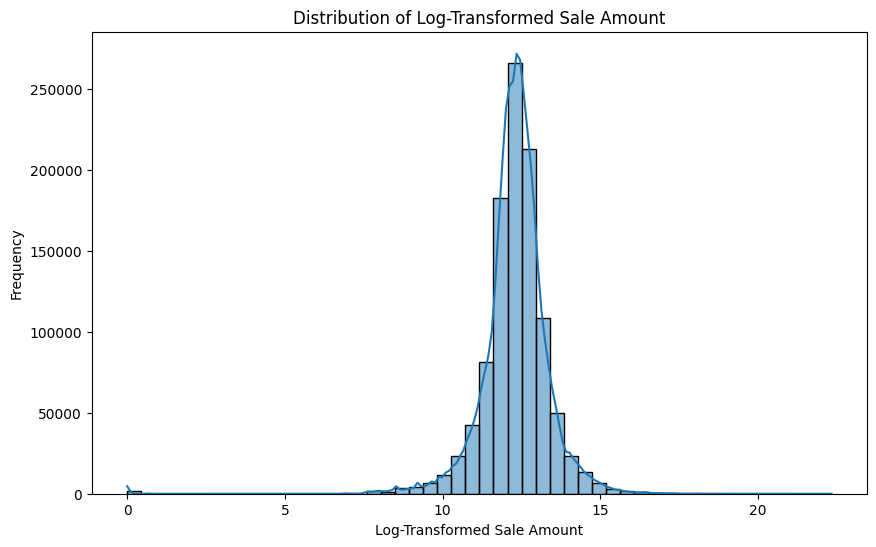

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Apply log transformation to 'Sale Amount', adding 1 to avoid log(0)
sales_data['Sale Amount Log'] = np.log1p(sales_data['Sale Amount'])

# Plot the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Sale Amount Log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Sale Amount')
plt.xlabel('Log-Transformed Sale Amount')
plt.ylabel('Frequency')
plt.show()


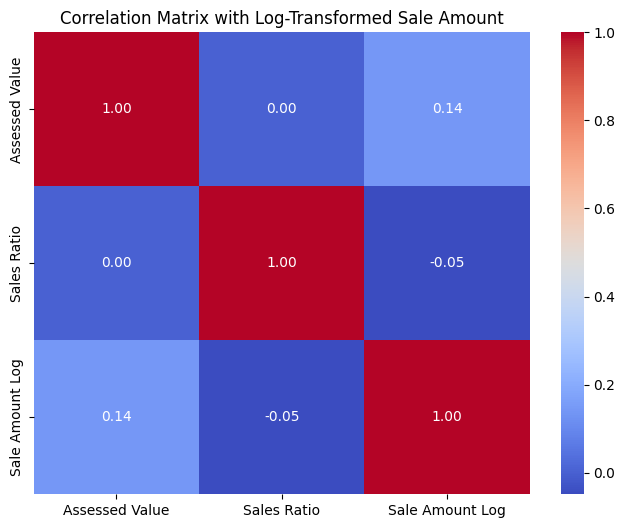

In [11]:
# Add the log-transformed 'Sale Amount Log' column to the correlation matrix
numeric_columns = ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']
correlation_matrix = sales_data[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix with Log-Transformed Sale Amount")
plt.show()


<ipython-input-12-bfc08f8e3e92>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=town_avg_sale_amount.index, y=town_avg_sale_amount.values, palette="viridis")


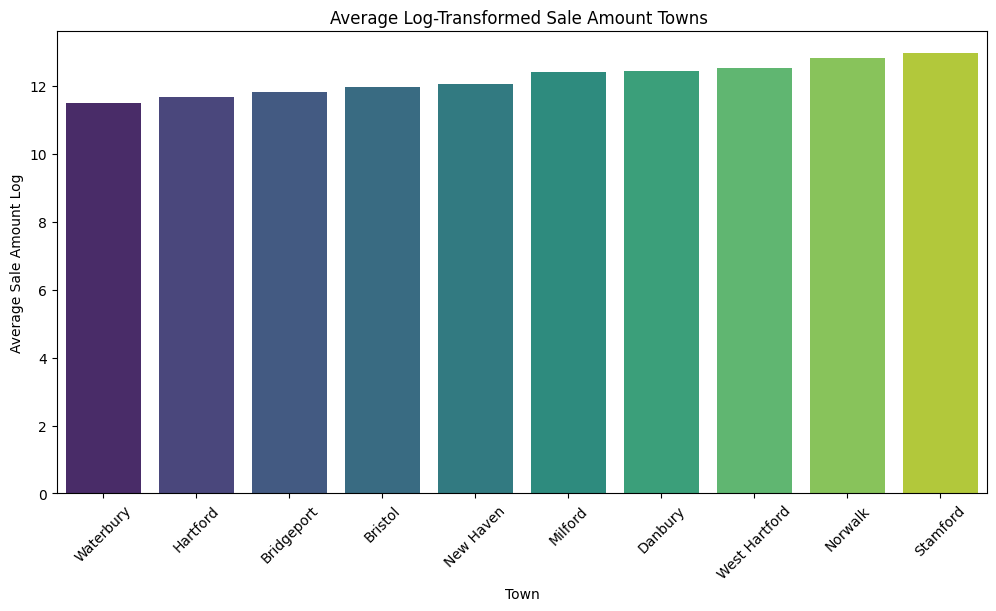

In [12]:
# Calculate the mean Sale Amount Log for each town and sort by frequency
top_towns = sales_data['Town'].value_counts().nlargest(10).index
town_avg_sale_amount = sales_data[sales_data['Town'].isin(top_towns)].groupby('Town')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Town
plt.figure(figsize=(12, 6))
sns.barplot(x=town_avg_sale_amount.index, y=town_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount Towns ')
plt.xlabel('Town')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


<ipython-input-13-6060e50aa871>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=property_type_avg_sale_amount.index, y=property_type_avg_sale_amount.values, palette="viridis")


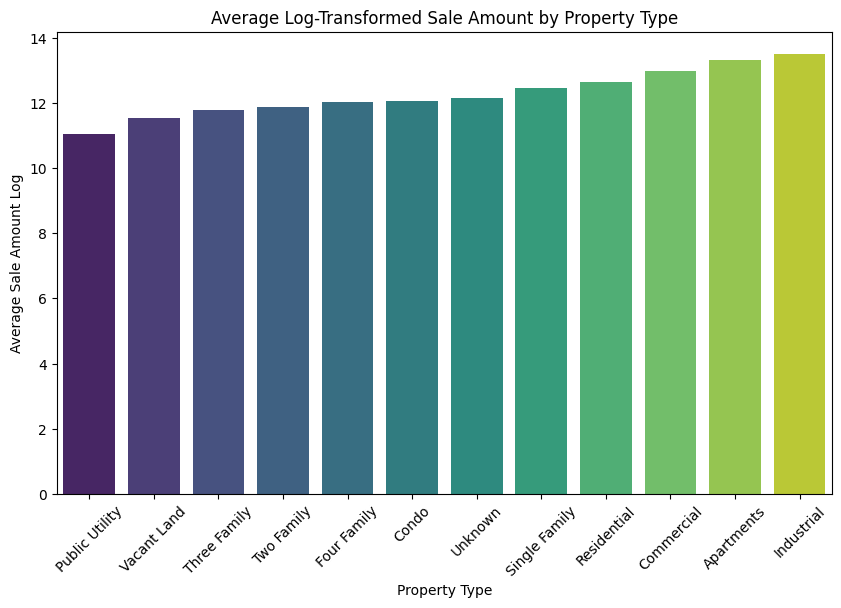

In [13]:
# Calculate the mean Sale Amount Log for each Property Type
property_type_avg_sale_amount = sales_data.groupby('Property Type')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Property Type
plt.figure(figsize=(10, 6))
sns.barplot(x=property_type_avg_sale_amount.index, y=property_type_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


<ipython-input-14-62286a986b20>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=residential_type_avg_sale_amount.index, y=residential_type_avg_sale_amount.values, palette="viridis")


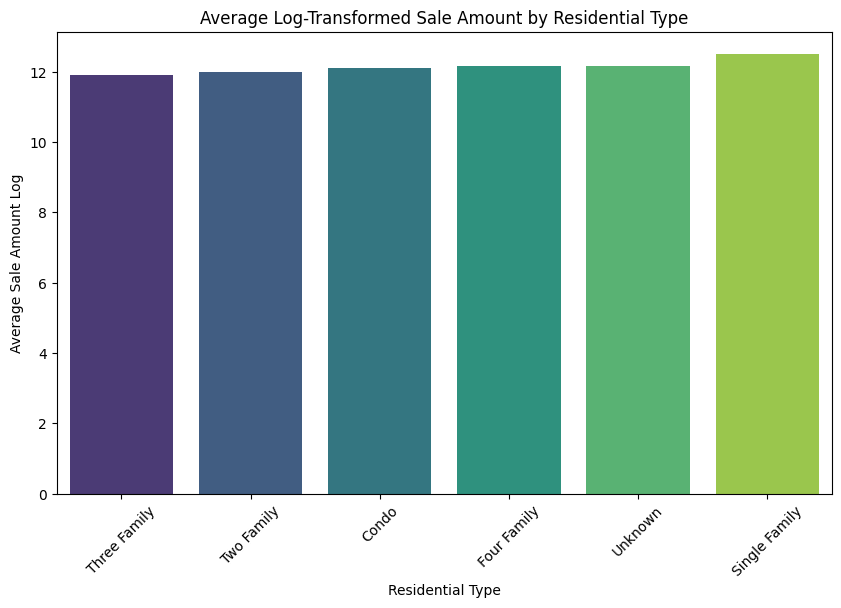

In [14]:
# Calculate the mean Sale Amount Log for each Residential Type
residential_type_avg_sale_amount = sales_data.groupby('Residential Type')['Sale Amount Log'].mean().sort_values()

# Plotting the average Sale Amount Log by Residential Type
plt.figure(figsize=(10, 6))
sns.barplot(x=residential_type_avg_sale_amount.index, y=residential_type_avg_sale_amount.values, palette="viridis")
plt.title('Average Log-Transformed Sale Amount by Residential Type')
plt.xlabel('Residential Type')
plt.ylabel('Average Sale Amount Log')
plt.xticks(rotation=45)
plt.show()


In [15]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Target Encoding for 'Town'
# Calculate mean Sale Amount Log for each town
town_target_mean = sales_data.groupby('Town')['Sale Amount Log'].mean()
# Map the mean Sale Amount Log to each town
sales_data['Town_Encoded'] = sales_data['Town'].map(town_target_mean)

# One-Hot Encoding for 'Property Type' and 'Residential Type'
# Use pandas get_dummies for one-hot encoding
sales_data = pd.get_dummies(sales_data, columns=['Property Type', 'Residential Type'], drop_first=True)

# Drop the original 'Town' column
sales_data.drop(columns=['Town'], inplace=True)

# Display the first few rows to confirm the encoding
print(sales_data.head())


   Assessed Value  Sale Amount  Sales Ratio Non Use Code  Sale Amount Log  \
0          133000     248400.0       0.5354      Unknown        12.422800   
1          110500     239900.0       0.4606      Unknown        12.387982   
2          150500     325000.0       0.4630      Unknown        12.691584   
3          127400     202500.0       0.6291      Unknown        12.218500   
4          217640     400000.0       0.5441      Unknown        12.899222   

   Town_Encoded  Property Type_Commercial  Property Type_Condo  \
0     12.054082                     False                False   
1     12.054082                     False                False   
2     12.054082                      True                False   
3     12.054082                     False                False   
4     12.767125                     False                False   

   Property Type_Four Family  Property Type_Industrial  ...  \
0                      False                     False  ...   
1             

In [16]:
# Drop Sale Amount if Sale Amount Log is the target
sales_data.drop(columns=['Sale Amount'], inplace=True)
# One-hot encode 'Non Use Code'
if 'Non Use Code' in sales_data.columns:
    sales_data = pd.get_dummies(sales_data, columns=['Non Use Code'], drop_first=True)
    print("Applied one-hot encoding to 'Non Use Code'.")

# Convert boolean columns to numeric
bool_columns = sales_data.select_dtypes(include=['bool']).columns
if len(bool_columns) > 0:
    sales_data[bool_columns] = sales_data[bool_columns].astype(int)
    print("Converted boolean columns to numeric.")

# Verify all columns are numeric
non_numeric_columns = sales_data.select_dtypes(exclude=['number']).columns
if len(non_numeric_columns) == 0:
    print("All columns are numeric. Dataset is ready for modeling!")
else:
    print(f"Non-numeric columns remain: {non_numeric_columns.tolist()}")

# Display the final shape and first few rows of the processed dataset
print(f"Final Sales Dataset Shape: {sales_data.shape}")
print(sales_data.head())


Applied one-hot encoding to 'Non Use Code'.
Converted boolean columns to numeric.
All columns are numeric. Dataset is ready for modeling!
Final Sales Dataset Shape: (1048575, 126)
   Assessed Value  Sales Ratio  Sale Amount Log  Town_Encoded  \
0          133000       0.5354        12.422800     12.054082   
1          110500       0.4606        12.387982     12.054082   
2          150500       0.4630        12.691584     12.054082   
3          127400       0.6291        12.218500     12.054082   
4          217640       0.5441        12.899222     12.767125   

   Property Type_Commercial  Property Type_Condo  Property Type_Four Family  \
0                         0                    0                          0   
1                         0                    0                          0   
2                         1                    0                          0   
3                         0                    0                          0   
4                         0       

In [17]:
# Apply Percentile Capping
for col in sales_data.select_dtypes(include=['float64', 'int64']).columns:
    lower_bound = sales_data[col].quantile(0.01)  # 1st percentile
    upper_bound = sales_data[col].quantile(0.99)  # 99th percentile
    sales_data[col] = sales_data[col].clip(lower=lower_bound, upper=upper_bound)

print("Percentile Capping applied.")
print(sales_data.describe())


Percentile Capping applied.
       Assessed Value   Sales Ratio  Sale Amount Log  Town_Encoded  \
count    1.048575e+06  1.048575e+06     1.048575e+06  1.048575e+06   
mean     2.223543e+05  7.995475e-01     1.231438e+01  1.229900e+01   
std      3.076911e+05  9.599892e-01     9.320277e-01  5.340584e-01   
min      2.500000e+03  9.544096e-03     9.210440e+00  1.149000e+01   
25%      8.841000e+04  4.818820e-01     1.186359e+01  1.193866e+01   
50%      1.395500e+05  6.171429e-01     1.234584e+01  1.219634e+01   
75%      2.267300e+05  7.775000e-01     1.282126e+01  1.254305e+01   
max      2.226718e+06  8.308520e+00     1.488022e+01  1.408139e+01   

       Property Type_Commercial  Property Type_Condo  \
count                 1048575.0         1.048575e+06   
mean                        0.0         1.005364e-01   
std                         0.0         3.007141e-01   
min                         0.0         0.000000e+00   
25%                         0.0         0.000000e+00   
50%  

In [18]:
import pandas as pd

# Calculate skewness for each numeric column
numeric_cols = sales_data.select_dtypes(include=['float64', 'int64']).columns
skewness = sales_data[numeric_cols].skew()

# Filter skewed columns (threshold: >0.5 or <-0.5)
skewed_cols = skewness[skewness.abs() > 0.5]

# Display skewed columns
print("Skewed Columns:")
print(skewed_cols)


Skewed Columns:
Assessed Value                          4.399101
Sales Ratio                             6.032529
Town_Encoded                            1.243072
Property Type_Condo                     2.656772
Property Type_Residential               2.632162
Property Type_Three Family              8.962432
Property Type_Two Family                6.060747
Property Type_Unknown                   0.562043
Residential Type_Three Family           8.058611
Residential Type_Two Family             5.418626
Residential Type_Unknown                0.514939
Non Use Code_07 - Change in Property    5.015017
Non Use Code_08 - Part Interest         7.766147
Non Use Code_14 - Foreclosure           4.081970
Non Use Code_25 - Other                 3.688776
Non Use Code_7                          8.316584
Non Use Code_Unknown                   -0.938808
dtype: float64


In [19]:
import numpy as np

# List of numeric, positive, highly skewed columns
skewed_numeric_cols = ['Assessed Value', 'Sales Ratio']

# Apply log1p (log(x + 1)) to handle skewness
for col in skewed_numeric_cols:
    sales_data[col] = np.log1p(sales_data[col])

print("Log transformation applied to:", skewed_numeric_cols)


Log transformation applied to: ['Assessed Value', 'Sales Ratio']


In [20]:
# Check skewness again
new_skewness = sales_data[skewed_numeric_cols].skew()
print("\nSkewness after log transformation:")
print(new_skewness)



Skewness after log transformation:
Assessed Value   -0.594987
Sales Ratio       3.135419
dtype: float64


In [21]:
# Apply capping to handle outliers
columns_to_cap = ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']

for col in columns_to_cap:
    Q1 = sales_data[col].quantile(0.25)
    Q3 = sales_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    sales_data[col] = sales_data[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers capped for:", columns_to_cap)


Outliers capped for: ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']


In [22]:
# Apply outlier removal
columns_to_check = ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']

for col in columns_to_check:
    Q1 = sales_data[col].quantile(0.25)
    Q3 = sales_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    sales_data = sales_data[(sales_data[col] >= lower_bound) & (sales_data[col] <= upper_bound)]

print(f"Dataset shape after removing outliers: {sales_data.shape}")


Dataset shape after removing outliers: (1048575, 126)


In [23]:
# Define columns to check for outliers
numeric_cols_to_check = ['Assessed Value', 'Sales Ratio','Sale Amount Log']

# Identify outliers using IQR
for col in numeric_cols_to_check:
    Q1 = sales_data[col].quantile(0.25)
    Q3 = sales_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales_data[(sales_data[col] < lower_bound) | (sales_data[col] > upper_bound)]
    print(f"Column '{col}': {len(outliers)} outliers detected.")


Column 'Assessed Value': 0 outliers detected.
Column 'Sales Ratio': 0 outliers detected.
Column 'Sale Amount Log': 0 outliers detected.


In [24]:
from sklearn.preprocessing import RobustScaler

# Robust Scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(sales_data)

# Convert scaled data back to a DataFrame
sales_data_scaled = pd.DataFrame(scaled_data, columns=sales_data.columns)

print("Robust Scaling applied.")
print(sales_data_scaled.describe())


Robust Scaling applied.
       Assessed Value   Sales Ratio  Sale Amount Log  Town_Encoded  \
count    1.048575e+06  1.048575e+06     1.048575e+06  1.048575e+06   
mean     1.660891e-02  8.302213e-02    -1.816449e-02  1.698511e-01   
std      8.744670e-01  9.104340e-01     8.760591e-01  8.836364e-01   
min     -1.984656e+00 -1.980211e+00    -2.003565e+00 -1.168694e+00   
25%     -4.846563e-01 -4.802112e-01    -5.035646e-01 -4.263442e-01   
50%      0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
75%      5.153437e-01  5.197888e-01     4.964354e-01  5.736558e-01   
max      2.015344e+00  2.019789e+00     1.996435e+00  3.118945e+00   

       Property Type_Commercial  Property Type_Condo  \
count                 1048575.0         1.048575e+06   
mean                        0.0         1.005364e-01   
std                         0.0         3.007141e-01   
min                         0.0         0.000000e+00   
25%                         0.0         0.000000e+00   
50%      

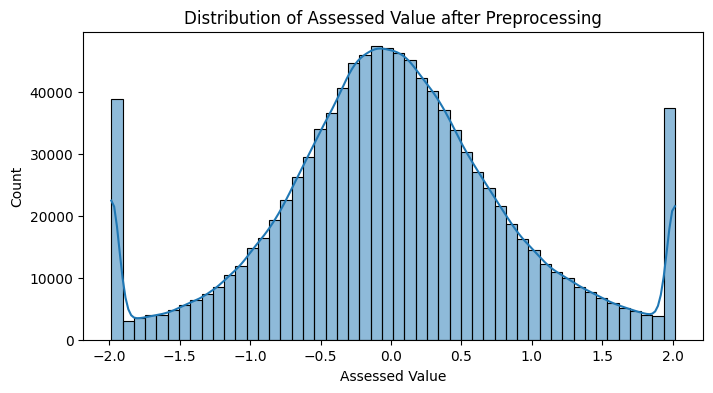

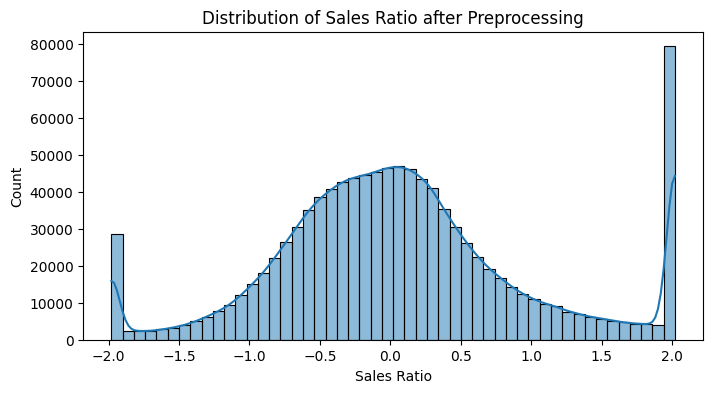

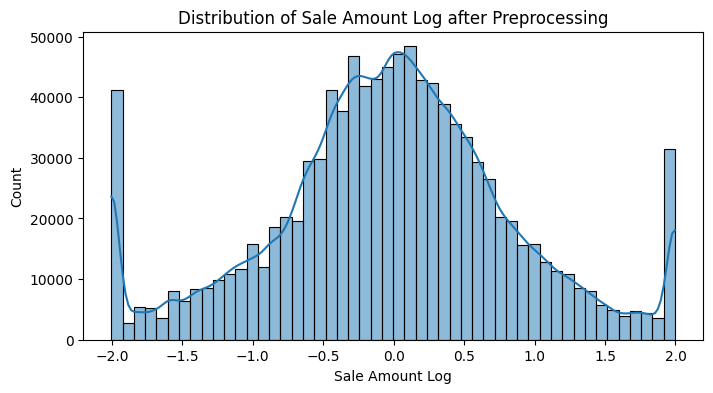

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distributions for key numeric columns
for col in ['Assessed Value', 'Sales Ratio', 'Sale Amount Log']:
    plt.figure(figsize=(8, 4))
    sns.histplot(sales_data_scaled[col], kde=True, bins=50)
    plt.title(f"Distribution of {col} after Preprocessing")
    plt.show()


In [26]:
low_variance_cols = [col for col in sales_data_scaled.columns if sales_data_scaled[col].std() == 0]
sales_data_scaled.drop(columns=low_variance_cols, inplace=True)
print(f"Removed low-variance columns: {low_variance_cols}")


Removed low-variance columns: ['Property Type_Commercial', 'Property Type_Four Family', 'Property Type_Industrial', 'Property Type_Public Utility', 'Property Type_Vacant Land', 'Residential Type_Four Family', 'Non Use Code_02 - Love and Affection', 'Non Use Code_03 - Inter Corporation', 'Non Use Code_04 - Correcting Deed', 'Non Use Code_05 - Deed Date', 'Non Use Code_06 - Portion of Property', 'Non Use Code_09 - Tax', 'Non Use Code_1', 'Non Use Code_1.0', 'Non Use Code_10', 'Non Use Code_10 - A Will', 'Non Use Code_10.0', 'Non Use Code_11', 'Non Use Code_11 - Court Order', 'Non Use Code_11.0', 'Non Use Code_12', 'Non Use Code_12 - Non Buildable Lot', 'Non Use Code_12.0', 'Non Use Code_13', 'Non Use Code_13 - Bankrupcy', 'Non Use Code_13.0', 'Non Use Code_14', 'Non Use Code_14.0', 'Non Use Code_15', 'Non Use Code_15 - Government Agency', 'Non Use Code_15.0', 'Non Use Code_16', 'Non Use Code_16 - Charitable Group', 'Non Use Code_16.0', 'Non Use Code_17', 'Non Use Code_17 - Two Towns', 'N

In [27]:
print(sales_data_scaled.isnull().sum())


Assessed Value                          0
Sales Ratio                             0
Sale Amount Log                         0
Town_Encoded                            0
Property Type_Condo                     0
Property Type_Residential               0
Property Type_Single Family             0
Property Type_Three Family              0
Property Type_Two Family                0
Property Type_Unknown                   0
Residential Type_Single Family          0
Residential Type_Three Family           0
Residential Type_Two Family             0
Residential Type_Unknown                0
Non Use Code_07 - Change in Property    0
Non Use Code_08 - Part Interest         0
Non Use Code_14 - Foreclosure           0
Non Use Code_25 - Other                 0
Non Use Code_7                          0
Non Use Code_Unknown                    0
dtype: int64


In [28]:
low_variance_cols = [col for col in sales_data_scaled.columns if sales_data_scaled[col].std() == 0]
print(f"Low variance columns: {low_variance_cols}")
sales_data_scaled.drop(columns=low_variance_cols, inplace=True)


Low variance columns: []


<Axes: >

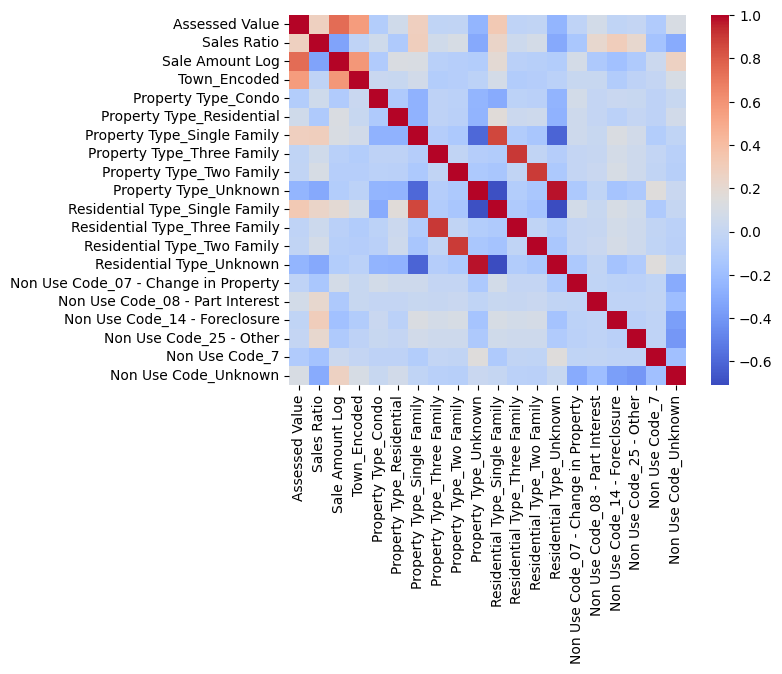

In [29]:
correlation_matrix = sales_data_scaled.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')


In [30]:
# Define features (X) and target (y)
sales_X = sales_data.drop(columns=['Sale Amount Log'])
sales_y = sales_data['Sale Amount Log']

# Print shapes to verify
print("Features Shape:", sales_X.shape)
print("Target Shape:", sales_y.shape)


Features Shape: (1048575, 125)
Target Shape: (1048575,)


In [31]:
print("Features Shape:", sales_X.shape)
print("Target Shape:", sales_y.shape)



Features Shape: (1048575, 125)
Target Shape: (1048575,)


In [32]:
from sklearn.model_selection import train_test_split
# train-test split 80 and 20
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
    sales_X, sales_y, test_size=0.2, random_state=42
)

#check the shapes of the splits
print("Dataset Split Summary:")
print(f"Training Features: {sales_X_train.shape}, Training Target: {sales_y_train.shape}")
print(f"Testing Features: {sales_X_test.shape}, Testing Target: {sales_y_test.shape}")


Dataset Split Summary:
Training Features: (838860, 125), Training Target: (838860,)
Testing Features: (209715, 125), Testing Target: (209715,)


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression

# Example model training
baseline_model = LinearRegression()
baseline_model.fit(sales_X_train, sales_y_train)


# Predict on the test set
sales_y_pred = baseline_model.predict(sales_X_test)

# Evaluate predictions
mae = mean_absolute_error(sales_y_test, sales_y_pred)
rmse = np.sqrt(mean_squared_error(sales_y_test, sales_y_pred))
r2 = r2_score(sales_y_test, sales_y_pred)

# Print evaluation metrics
print("Sales Dataset - Prediction Results:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


Sales Dataset - Prediction Results:
  MAE: 0.1300
  RMSE: 0.2811
  R² Score: 0.8881


In [72]:
# Reverse the log transformation to get the original prices
sales_y_test_original = np.expm1(sales_y_test)
sales_y_pred_original = np.expm1(sales_y_pred)
# predictions vs actual values in original scale
predictions_vs_actuals_original = pd.DataFrame({
    "Actual Price (Dollars)": sales_y_test_original,
    "Predicted Price (Dollars)": sales_y_pred_original,
    "Difference (Dollars)": sales_y_test_original - sales_y_pred_original
}).iloc[:20]

print("\nTop 20 Predictions vs Actual Values ")
print(predictions_vs_actuals_original)



Top 20 Predictions vs Actual Values 
         Actual Price (Dollars)  Predicted Price (Dollars)  \
781974                 330000.0              331586.150060   
937737                 230000.0              228522.802286   
907828                 400000.0              399974.492124   
784628                 201000.0              202614.177405   
662460                 140000.0              139690.605290   
280139                  60000.0               58533.026578   
355572                  98000.0              107451.671768   
749979                 230000.0              228789.365860   
374753                 140000.0              140571.117978   
17327                  255000.0              253550.376297   
658472                 125000.0               68713.484196   
700377                 160000.0              159899.366587   
880383                 580000.0              571814.146290   
677181                 179000.0              178288.386727   
18941                  370000.0 

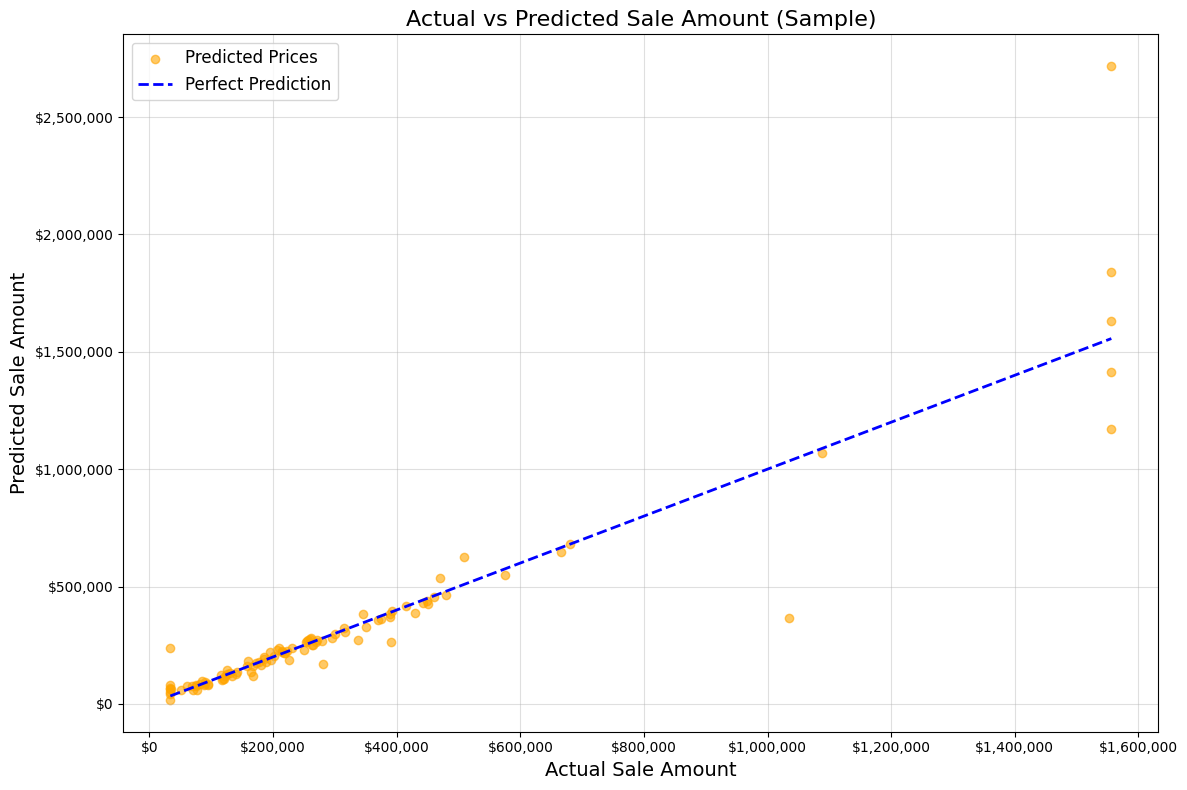

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Reset index to ensure sequential indexing for sampling
actual_prices = np.expm1(sales_y_test.reset_index(drop=True))  # Reverse log1p transformation
predicted_prices = np.expm1(sales_y_pred)

# Take a smaller sample of data for clear visualization
sample_indices = np.random.choice(len(actual_prices), size=100, replace=False)  # 50 for cleaner graph
sample_actual_prices = actual_prices.iloc[sample_indices]
sample_predicted_prices = predicted_prices[sample_indices]

# Scatter plot for actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_prices, sample_predicted_prices,
            label="Predicted Prices", alpha=0.6, color='orange')
plt.plot([min(sample_actual_prices), max(sample_actual_prices)],
         [min(sample_actual_prices), max(sample_actual_prices)],
         label="Perfect Prediction", color='blue', linestyle='--', linewidth=2)

# Enhance the graph
plt.title("Actual vs Predicted Sale Amount (Sample)", fontsize=16)
plt.xlabel("Actual Sale Amount", fontsize=14)
plt.ylabel("Predicted Sale Amount", fontsize=14)
plt.legend(fontsize=12)

# Format axes with commas for large numbers
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.grid(alpha=0.4)
plt.tight_layout()

# Display the plot
plt.show()


In [37]:
!pip install lightgbm


In [42]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# # Prepare data for LightGBM
train_data = lgb.Dataset(sales_X_train, label=sales_y_train)
test_data = lgb.Dataset(sales_X_test, label=sales_y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}

# Train the model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Predict on test data
sales_y_pred = lgb_model.predict(sales_X_test, num_iteration=lgb_model.best_iteration)

# Calculate metrics
mae = mean_absolute_error(sales_y_test, sales_y_pred)
rmse = np.sqrt(mean_squared_error(sales_y_test, sales_y_pred))
r2 = r2_score(sales_y_test, sales_y_pred)

print("LightGBM Model Performance:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 12.328264
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.176224	valid's rmse: 0.179936
[200]	train's rmse: 0.170819	valid's rmse: 0.176116
[300]	train's rmse: 0.16761	valid's rmse: 0.174411
[400]	train's rmse: 0.165771	valid's rmse: 0.173634
[500]	train's rmse: 0.164009	valid's rmse: 0.172819
[600]	train's rmse: 0.162814	valid's rmse: 0.172447
[700]	train's rmse: 0.161845	valid's rmse: 0.172162
[800]	tra

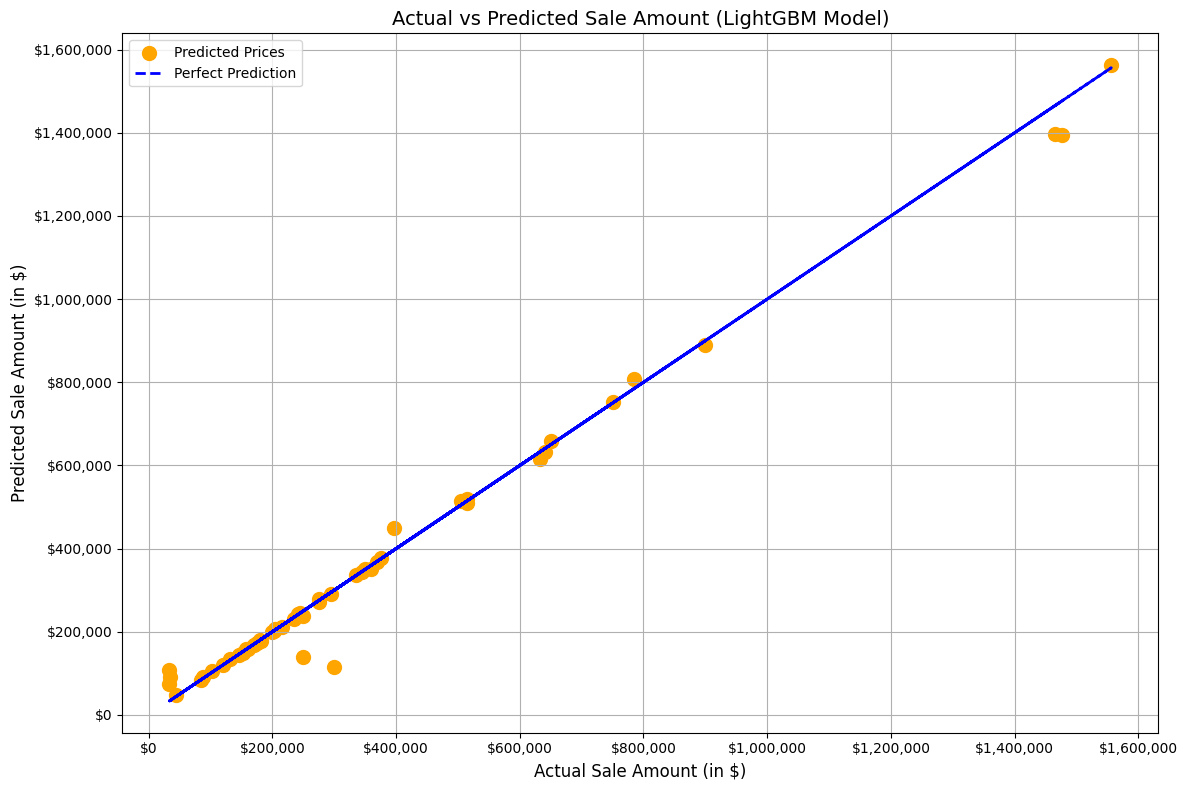

In [43]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define actual and predicted values
actual_values = np.expm1(sales_y_test.reset_index(drop=True))
predicted_values = np.expm1(sales_y_pred)

# Sample only 50 predictions for a cleaner graph
sample_indices = np.random.choice(len(actual_values), size=50, replace=False)
sample_actual_values = actual_values.iloc[sample_indices].reset_index(drop=True)
sample_predictions = pd.Series(predicted_values[sample_indices]).reset_index(drop=True)

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_values, sample_predictions, color="orange", label="Predicted Prices", s=100)
plt.plot(sample_actual_values, sample_actual_values, color="blue", linestyle="--", label="Perfect Prediction", linewidth=2)

# Format axes to show dollar values
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Customize the plot
plt.xlabel("Actual Sale Amount (in $)", fontsize=12)
plt.ylabel("Predicted Sale Amount (in $)", fontsize=12)
plt.title("Actual vs Predicted Sale Amount (LightGBM Model)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
import pandas as pd
import numpy as np

# Reverse the log transformation for original prices
sales_y_test_original = np.expm1(sales_y_test)
sales_y_pred_original = np.expm1(sales_y_pred)

# Create a DataFrame for predictions vs actual values
lightgbm_results_df = pd.DataFrame({
    "Actual Price (Dollars)": sales_y_test_original,
    "Predicted Price (Dollars)": sales_y_pred_original,
    "Difference (Dollars)": sales_y_test_original - sales_y_pred_original}).reset_index(drop=True)

# Extract the first 20 rows
results = lightgbm_results_df.iloc[:20]

# Display the top 20 results
print("\nTop 20 Predictions vs Actual Values :")
print(results)



Top 20 Predictions vs Actual Values :
    Actual Price (Dollars)  Predicted Price (Dollars)  Difference (Dollars)
0                 330000.0              331586.150060          -1586.150060
1                 230000.0              228522.802286           1477.197714
2                 400000.0              399974.492124             25.507876
3                 201000.0              202614.177405          -1614.177405
4                 140000.0              139690.605290            309.394710
5                  60000.0               58533.026578           1466.973422
6                  98000.0              107451.671768          -9451.671768
7                 230000.0              228789.365860           1210.634140
8                 140000.0              140571.117978           -571.117978
9                 255000.0              253550.376297           1449.623703
10                125000.0               68713.484196          56286.515804
11                160000.0              159899.36

In [45]:
# Drop only the columns that exist in the dataset
redundant_features = [
    'Property Type_Single Family',
    'Property Type_Three Family',
    'Property Type_Two Family',
    'Property Type_Unknown'
]

# columns that are not present in sales_X_train
redundant_features = [col for col in redundant_features if col in sales_X_train.columns]

# Drop the verified redundant features
sales_X_train_reduced = sales_X_train.drop(columns=redundant_features)
sales_X_test_reduced = sales_X_test.drop(columns=redundant_features)

print("Remaining features after dropping redundant ones:", sales_X_train_reduced.columns.tolist())


Remaining features after dropping redundant ones: ['Assessed Value', 'Sales Ratio', 'Town_Encoded', 'Property Type_Commercial', 'Property Type_Condo', 'Property Type_Four Family', 'Property Type_Industrial', 'Property Type_Public Utility', 'Property Type_Residential', 'Property Type_Vacant Land', 'Residential Type_Four Family', 'Residential Type_Single Family', 'Residential Type_Three Family', 'Residential Type_Two Family', 'Residential Type_Unknown', 'Non Use Code_02 - Love and Affection', 'Non Use Code_03 - Inter Corporation', 'Non Use Code_04 - Correcting Deed', 'Non Use Code_05 - Deed Date', 'Non Use Code_06 - Portion of Property', 'Non Use Code_07 - Change in Property', 'Non Use Code_08 - Part Interest', 'Non Use Code_09 - Tax', 'Non Use Code_1', 'Non Use Code_1.0', 'Non Use Code_10', 'Non Use Code_10 - A Will', 'Non Use Code_10.0', 'Non Use Code_11', 'Non Use Code_11 - Court Order', 'Non Use Code_11.0', 'Non Use Code_12', 'Non Use Code_12 - Non Buildable Lot', 'Non Use Code_12.0'

In [49]:
# Identify truly constant columns
constant_columns = [col for col in sales_data.columns if sales_data[col].nunique() <= 1]

# Remove only existing constant columns
constant_columns_existing = [col for col in constant_columns if col in sales_data.columns]
if constant_columns_existing:
    sales_data.drop(columns=constant_columns_existing, inplace=True)
    print(f"Dropped existing constant columns: {constant_columns_existing}")
else:
    print("No constant columns found to drop.")

# Updated dataset shape
print("Updated dataset shape:", sales_data.shape)


Dropped existing constant columns: ['Property Type_Commercial', 'Property Type_Four Family', 'Property Type_Industrial', 'Property Type_Public Utility', 'Property Type_Vacant Land', 'Residential Type_Four Family', 'Non Use Code_02 - Love and Affection', 'Non Use Code_03 - Inter Corporation', 'Non Use Code_04 - Correcting Deed', 'Non Use Code_05 - Deed Date', 'Non Use Code_06 - Portion of Property', 'Non Use Code_09 - Tax', 'Non Use Code_1', 'Non Use Code_1.0', 'Non Use Code_10', 'Non Use Code_10 - A Will', 'Non Use Code_10.0', 'Non Use Code_11', 'Non Use Code_11 - Court Order', 'Non Use Code_11.0', 'Non Use Code_12', 'Non Use Code_12 - Non Buildable Lot', 'Non Use Code_12.0', 'Non Use Code_13', 'Non Use Code_13 - Bankrupcy', 'Non Use Code_13.0', 'Non Use Code_14', 'Non Use Code_14.0', 'Non Use Code_15', 'Non Use Code_15 - Government Agency', 'Non Use Code_15.0', 'Non Use Code_16', 'Non Use Code_16 - Charitable Group', 'Non Use Code_16.0', 'Non Use Code_17', 'Non Use Code_17 - Two Towns

In [51]:
from sklearn.model_selection import train_test_split

# Define features and target
sales_X = sales_data.drop(columns=['Sale Amount Log'])
sales_y = sales_data['Sale Amount Log']

# Split into training and testing sets (80-20 split)
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(
    sales_X, sales_y, test_size=0.2, random_state=42)

# Checking shapes
print(f"Training Features Shape: {sales_X_train.shape}")
print(f"Testing Features Shape: {sales_X_test.shape}")
print(f"Training Target Shape: {sales_y_train.shape}")
print(f"Testing Target Shape: {sales_y_test.shape}")


Training Features Shape: (838860, 19)
Testing Features Shape: (209715, 19)
Training Target Shape: (838860,)
Testing Target Shape: (209715,)


In [52]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# transform both training and testing data
sales_X_train_scaled = scaler.fit_transform(sales_X_train)
sales_X_test_scaled = scaler.transform(sales_X_test)


Scaled Training Features Mean: [-1.45762651e-15 -4.18434675e-18  7.45152535e-16 -5.81488673e-17
 -6.27821419e-17 -1.35610104e-17 -2.54533643e-17 -2.77149445e-17
 -4.34104799e-17  4.09879634e-17 -3.97258831e-18 -6.42729213e-17
 -1.17246412e-16 -1.78046495e-17  5.17114107e-17  5.80218122e-17
 -9.14796455e-19 -1.07573287e-17 -4.65529752e-17]
Scaled Training Features Std Dev: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Step 2: Define the model architecture
dl_model_reduced = Sequential([
    Dense(128, activation='relu', input_shape=(sales_X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Step 3: Compile the model
dl_model_reduced.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Step 4: Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history_reduced = dl_model_reduced.fit(
    sales_X_train_scaled, sales_y_train,
    validation_data=(sales_X_test_scaled, sales_y_test),
    epochs=50,
    batch_size=16,
    verbose=1,
     callbacks=[early_stopping]
)

# Step 6: Evaluate the model
dl_loss_reduced, dl_mae_reduced = dl_model_reduced.evaluate(sales_X_test_scaled, sales_y_test, verbose=0)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52429/52429 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - loss: 0.9829 - mae: 0.4323 - val_loss: 0.0680 - val_mae: 0.1310
Epoch 2/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0632 - mae: 0.1262 - val_loss: 0.0790 - val_mae: 0.1690
Epoch 3/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0600 - mae: 0.1183 - val_loss: 0.1037 - val_mae: 0.2062
Epoch 4/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - loss: 0.0588 - mae: 0.1145 - val_loss: 0.0860 - val_mae: 0.1779
Epoch 5/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0575 - mae: 0.1126 - val_loss: 0.0850 - val_mae: 0.1860
Epoch 6/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0572 - mae: 0.1124 - val_loss: 0.0782 - val_mae: 0.1768
Epoch 7/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 0.0565 - mae: 0.1099 - val_loss: 0.0664 - val_mae: 0.1515
Epoch 8/50
52429/52429 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - loss: 0.0561 - mae: 0.1093 - val_loss: 0.0991 - val_mae: 0.2024
Epoch 9/50
52429/52429 ━━━━

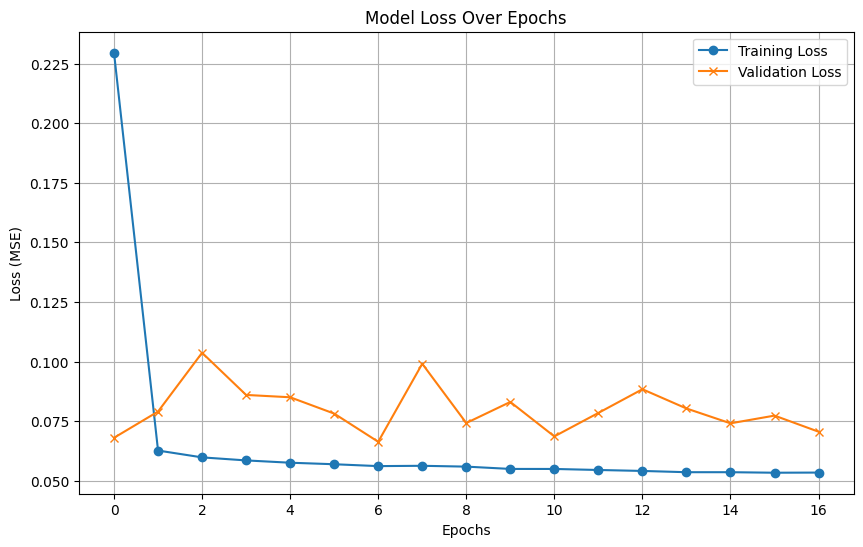

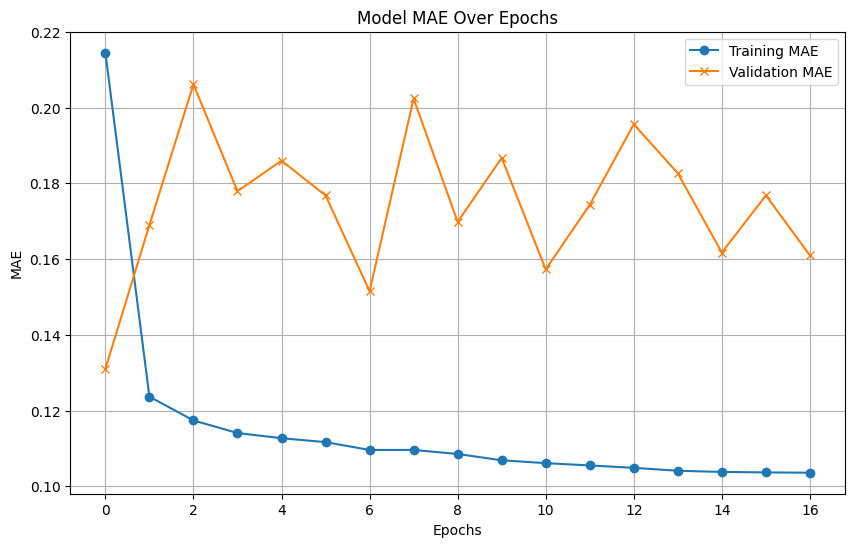

In [63]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_reduced.history['loss'], label='Training Loss', marker='o')
plt.plot(history_reduced.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history_reduced.history['mae'], label='Training MAE', marker='o')
plt.plot(history_reduced.history['val_mae'], label='Validation MAE', marker='x')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predict on the test data
sales_y_pred_dl = dl_model_reduced.predict(sales_X_test_scaled)

# Calculate R² Score
r2 = r2_score(sales_y_test, sales_y_pred_dl)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sales_y_test, sales_y_pred_dl))

# Print results
print("\nDeep Learning Model :")
print(f"  Loss (MSE): {dl_loss_reduced:.4f}")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE: {rmse:.4f}")


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Deep Learning Model :
  Loss (MSE): 0.0664
  R² Score: 0.9061
  RMSE: 0.2576


In [62]:
# Predict on the test data
sales_y_pred_dl = dl_model_reduced.predict(sales_X_test_scaled)

# Convert predictions back to the original scale
sales_y_pred_original_scale = np.exp(sales_y_pred_dl.flatten())
sales_y_test_original_scale = np.exp(sales_y_test)

# Preview actual vs predicted with difference
print("\nSample Comparison of Actual vs Predicted:")
print(comparison_df.head(10))


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Sample Comparison of Actual vs Predicted:
        Actual Price  Predicted Price    Difference
781974      330001.0    303452.125000  26548.875000
937737      230001.0    235506.203125  -5505.203125
907828      400001.0    363129.937500  36871.062500
784628      201001.0    211948.406250 -10947.406250
662460      140001.0    152228.921875 -12227.921875
280139       60001.0     74806.710938 -14805.710937
355572       98001.0     91594.281250   6406.718750
749979      230001.0    231248.187500  -1247.187500
374753      140001.0    148691.781250  -8690.781250
17327       255001.0    238322.046875  16678.953125


6554/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


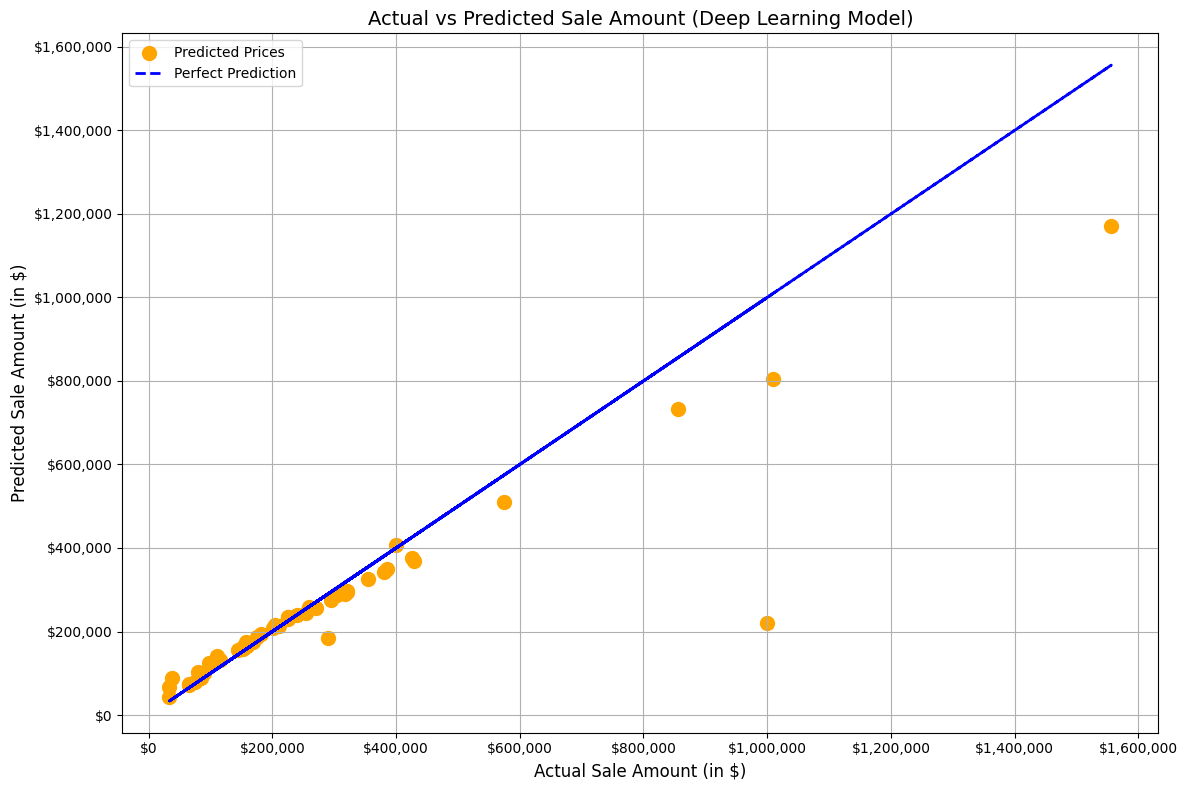

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

# Reverse the log transformation for actual and predicted values
actual_values = np.expm1(sales_y_test.reset_index(drop=True))  # Convert actual values to original scale
predicted_values = np.expm1(dl_model_reduced.predict(sales_X_test_scaled))  # Convert predicted values to original scale

# Sample only 50 predictions for a cleaner graph
sample_indices = np.random.choice(len(actual_values), size=50, replace=False)
sample_actual_values = actual_values.iloc[sample_indices].reset_index(drop=True)
sample_predictions = pd.Series(predicted_values[sample_indices].flatten()).reset_index(drop=True)

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 8))
plt.scatter(sample_actual_values, sample_predictions, color="orange", label="Predicted Prices", s=100)
plt.plot(sample_actual_values, sample_actual_values, color="blue", linestyle="--", label="Perfect Prediction", linewidth=2)

# Format axes to show dollar values
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Customize the plot
plt.xlabel("Actual Sale Amount (in $)", fontsize=12)
plt.ylabel("Predicted Sale Amount (in $)", fontsize=12)
plt.title("Actual vs Predicted Sale Amount (Deep Learning Model)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-78-6167cefb1745>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('Bin').mean()


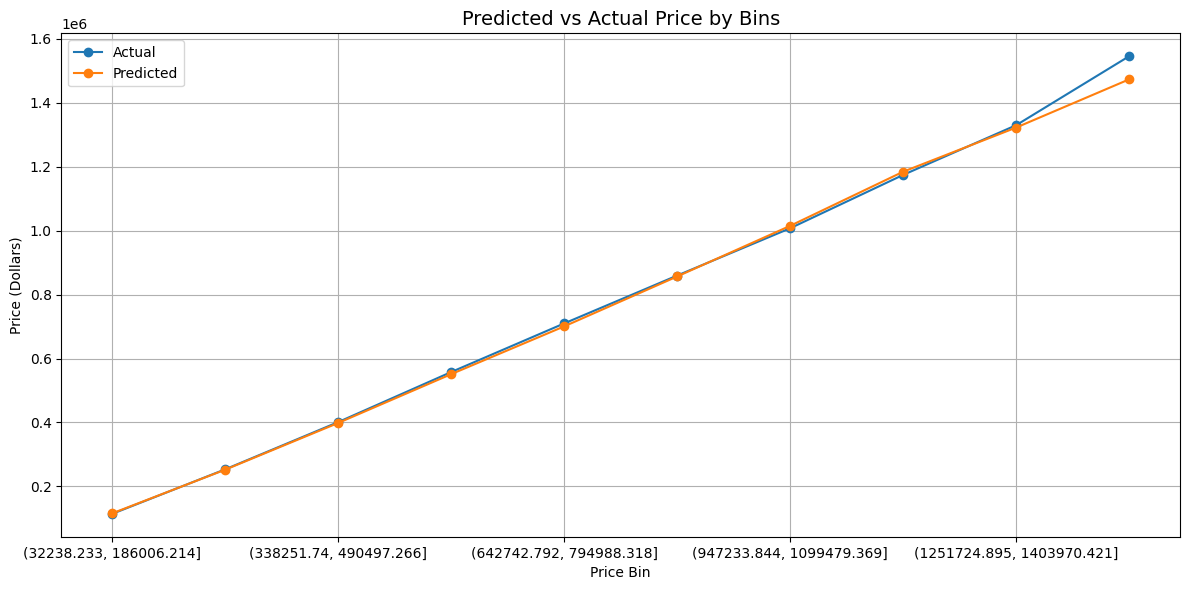

In [78]:
binned_actual = pd.cut(sales_y_test_original, bins=10)
binned_data = pd.DataFrame({
    'Actual': sales_y_test_original,
    'Predicted': sales_y_pred_original,
    'Bin': binned_actual
}).groupby('Bin').mean()

binned_data.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Predicted vs Actual Price by Bins', fontsize=14)
plt.xlabel('Price Bin')
plt.ylabel('Price (Dollars)')
plt.grid(True)
plt.tight_layout()
plt.show()


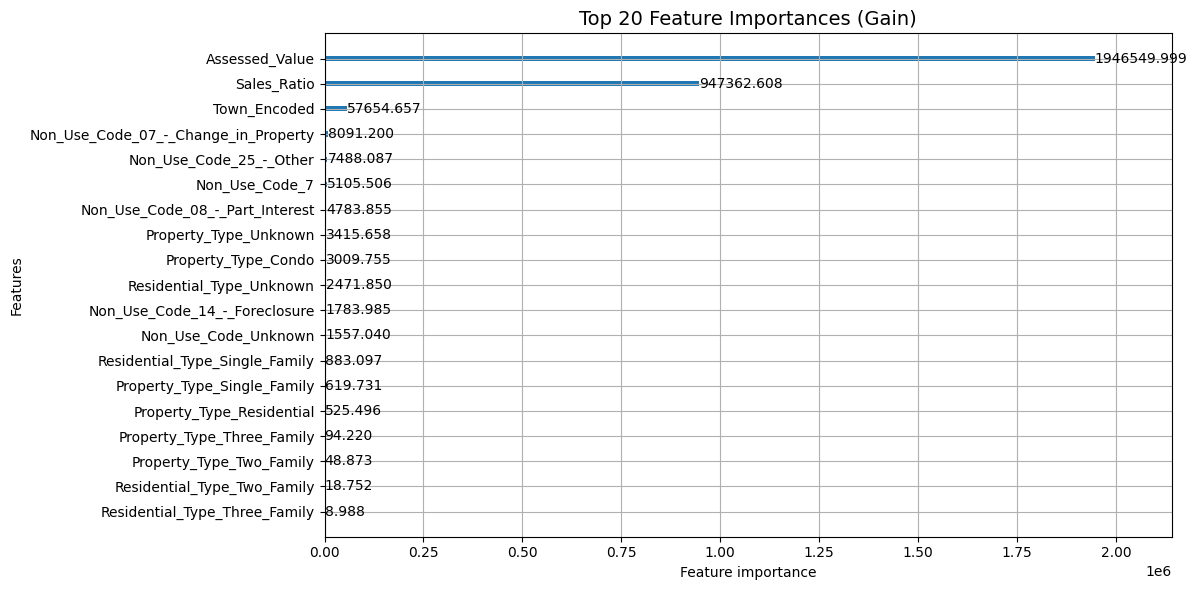

In [82]:
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(12, 6))
plt.title('Top 20 Feature Importances (Gain)', fontsize=14)
plt.tight_layout()
plt.show()
